Loading the dataset, clean, and process the info (code provided), create a k-means solution.

In [35]:

import numpy as np
import pandas as pd
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.cluster import AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn import datasets, metrics
from sqlalchemy import create_engine
import warnings
from num2words import num2words
warnings.filterwarnings("ignore") 


# load the dataset

####################################
## make id not visible

postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'
####################################


engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))

heartdisease_df = pd.read_sql_query('select * from heartdisease', con = engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [36]:
heartdisease_df

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,63.0,1.0,1.0,145.0,233.0,1.0,2.0,150.0,0.0,2.3,3.0,0.0,6.0,0
1,67.0,1.0,4.0,160.0,286.0,0.0,2.0,108.0,1.0,1.5,2.0,3.0,3.0,2
2,67.0,1.0,4.0,120.0,229.0,0.0,2.0,129.0,1.0,2.6,2.0,2.0,7.0,1
3,37.0,1.0,3.0,130.0,250.0,0.0,0.0,187.0,0.0,3.5,3.0,0.0,3.0,0
4,41.0,0.0,2.0,130.0,204.0,0.0,2.0,172.0,0.0,1.4,1.0,0.0,3.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
298,45.0,1.0,1.0,110.0,264.0,0.0,0.0,132.0,0.0,1.2,2.0,0.0,7.0,1
299,68.0,1.0,4.0,144.0,193.0,1.0,0.0,141.0,0.0,3.4,2.0,2.0,7.0,2
300,57.0,1.0,4.0,130.0,131.0,0.0,0.0,115.0,1.0,1.2,2.0,1.0,7.0,3
301,57.0,0.0,2.0,130.0,236.0,0.0,2.0,174.0,0.0,0.0,2.0,1.0,3.0,1


In [37]:
# make sure the number of rows divides evenly into four samples
# this is for evaluating clusteres
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
heartdisease_df = heartdisease_df.iloc[:rows, :]

# Define the features and the outcome
X = heartdisease_df.iloc[:, :13]
y = heartdisease_df.iloc[:, 13]

# Replace missing values (marked by ?) with a 0
X = X.replace(to_replace = '?', value = 0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Standarizing the features
std = StandardScaler().fit_transform(X)

# defining the k-means
kmeans_cluster = KMeans(n_clusters=2, random_state=123)

# fit model
%timeit kmeans_cluster.fit(std)
y_pred = kmeans_cluster.predict(std)

# reduce it to two components for visualization
pca = PCA(n_components = 2).fit_transform(std)

32.3 ms ± 1.8 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


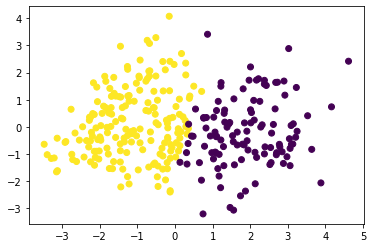

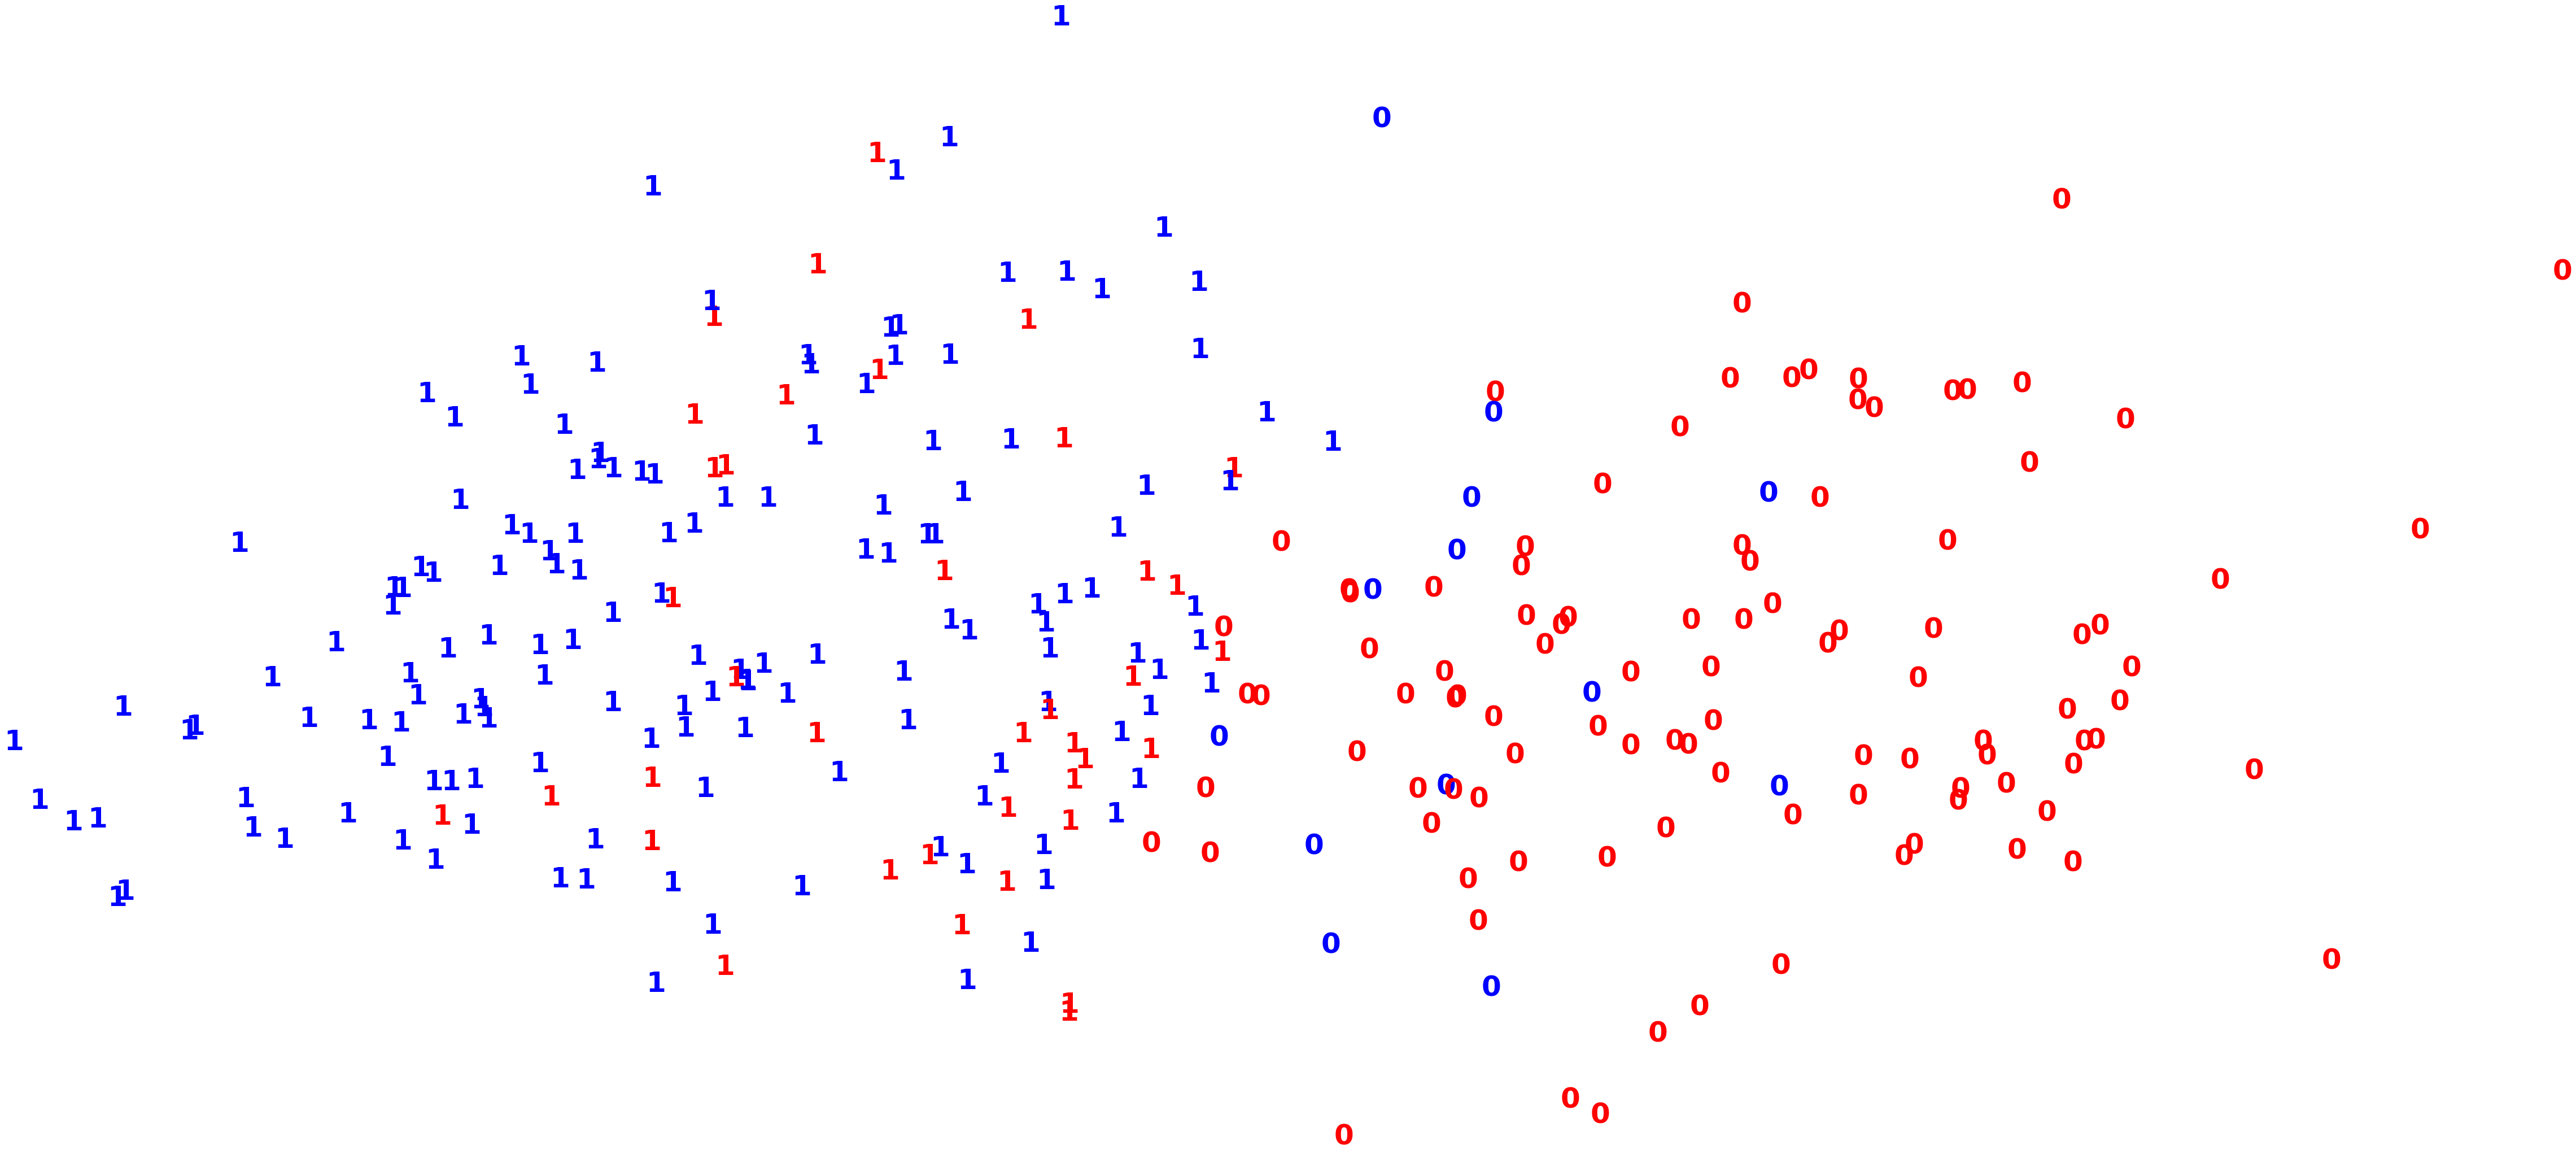

Comparing k-means clusters against the data:
col_0    0    1
row_0          
0      101   13
1       38  150


In [38]:
# plot the solution.
plt.scatter(pca[:, 0], pca[:, 1], c = y_pred)
plt.show()

# other plot
plt.figure(figsize = (10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(y_pred[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

# Check the solution against the data.
print('Comparing k-means clusters against the data:')
print(pd.crosstab(y_pred, y))

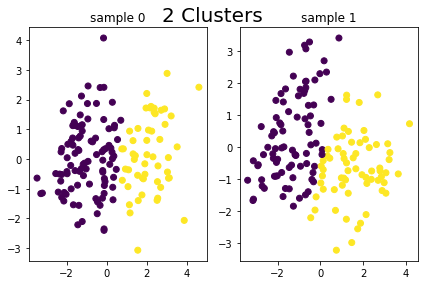

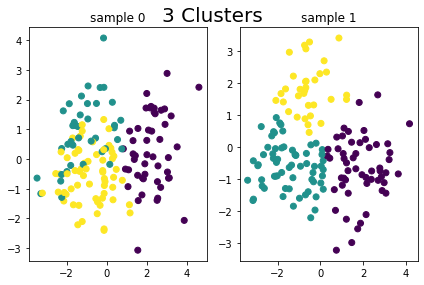

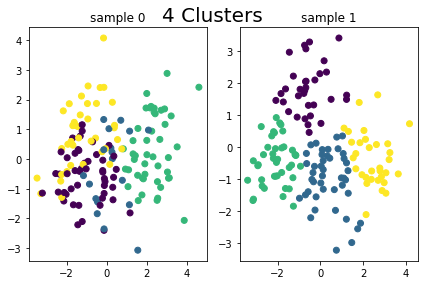



ARI for two cluster k-means: 0.43661540614807665
ARI for three cluster k-means: 0.280694132678885
ARI for four cluster k-means: 0.19162596502170298
Silhouette Coefficient for two cluster k-means: 0.17440650461256255
Silhouette Coefficient for three cluster k-means: 0.12862190702187828
Silhouette Coefficient for four cluster k-means: 0.1314736248593191


In [39]:
# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    std,
    pca,
    test_size  = 0.5,
    random_state = 123)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[counter])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()
    print('\n')

# get the ari score
for n in range(2, 5):
    pred = KMeans(n_clusters = n, random_state = 123).fit_predict(std)
    print("ARI for {} cluster k-means: {}".format(num2words(n), metrics.adjusted_rand_score(y, pred)))

# get the silhouette coefficient
for n in range(2, 5):
    pred = KMeans(n_clusters = n, random_state = 123).fit_predict(std)
    print("Silhouette Coefficient for {} cluster k-means: {}".format(num2words(n), metrics.silhouette_score(std, pred, metric='euclidean')))

Plot for complete


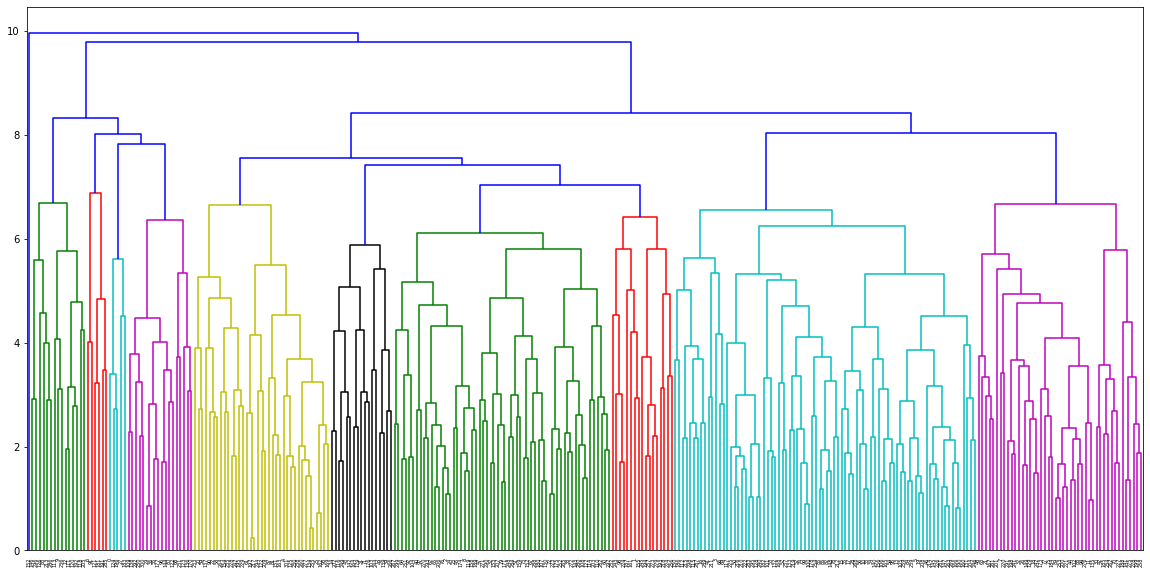

Plot for average


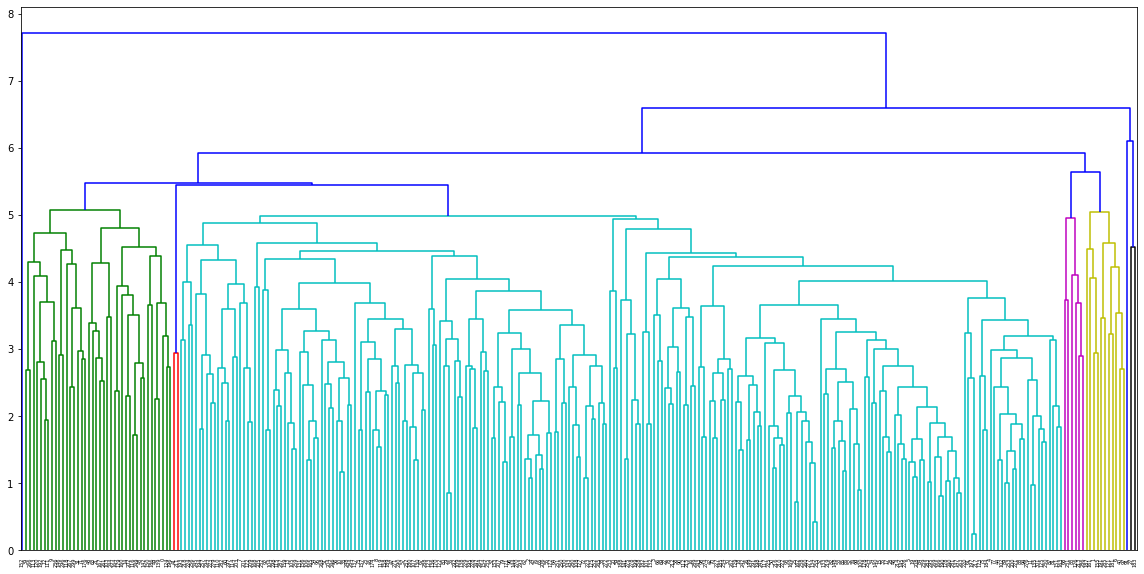

Plot for ward


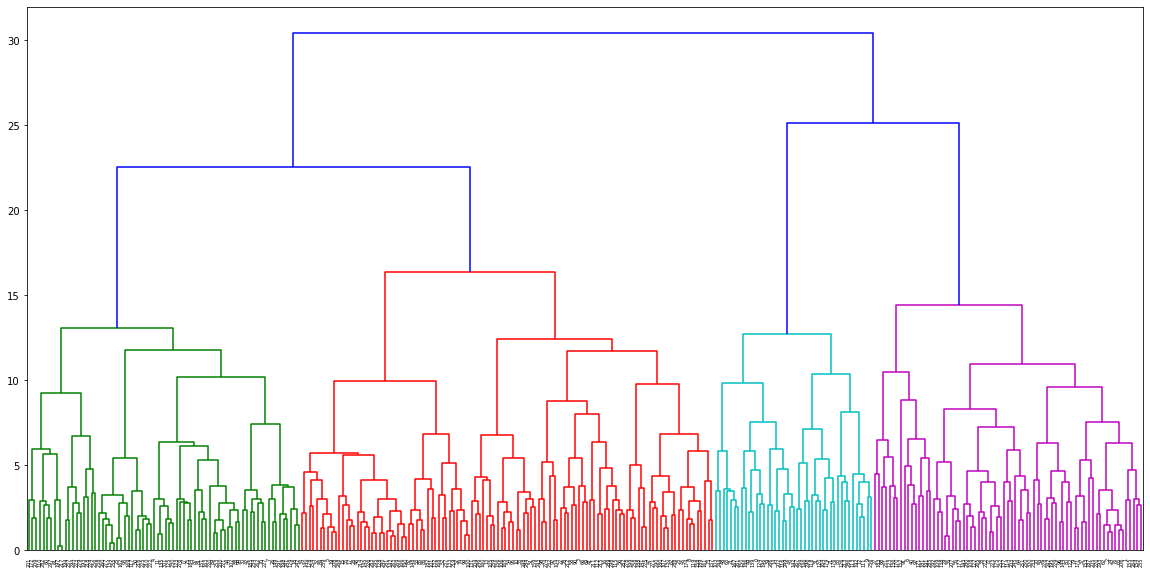

In [45]:

methods = ['complete', 'average', 'ward']
for m in methods:
    print('Plot for {}'.format(m))
    plt.figure(figsize=(20,10))
    dendrogram(linkage(std, method = m))
    plt.show()

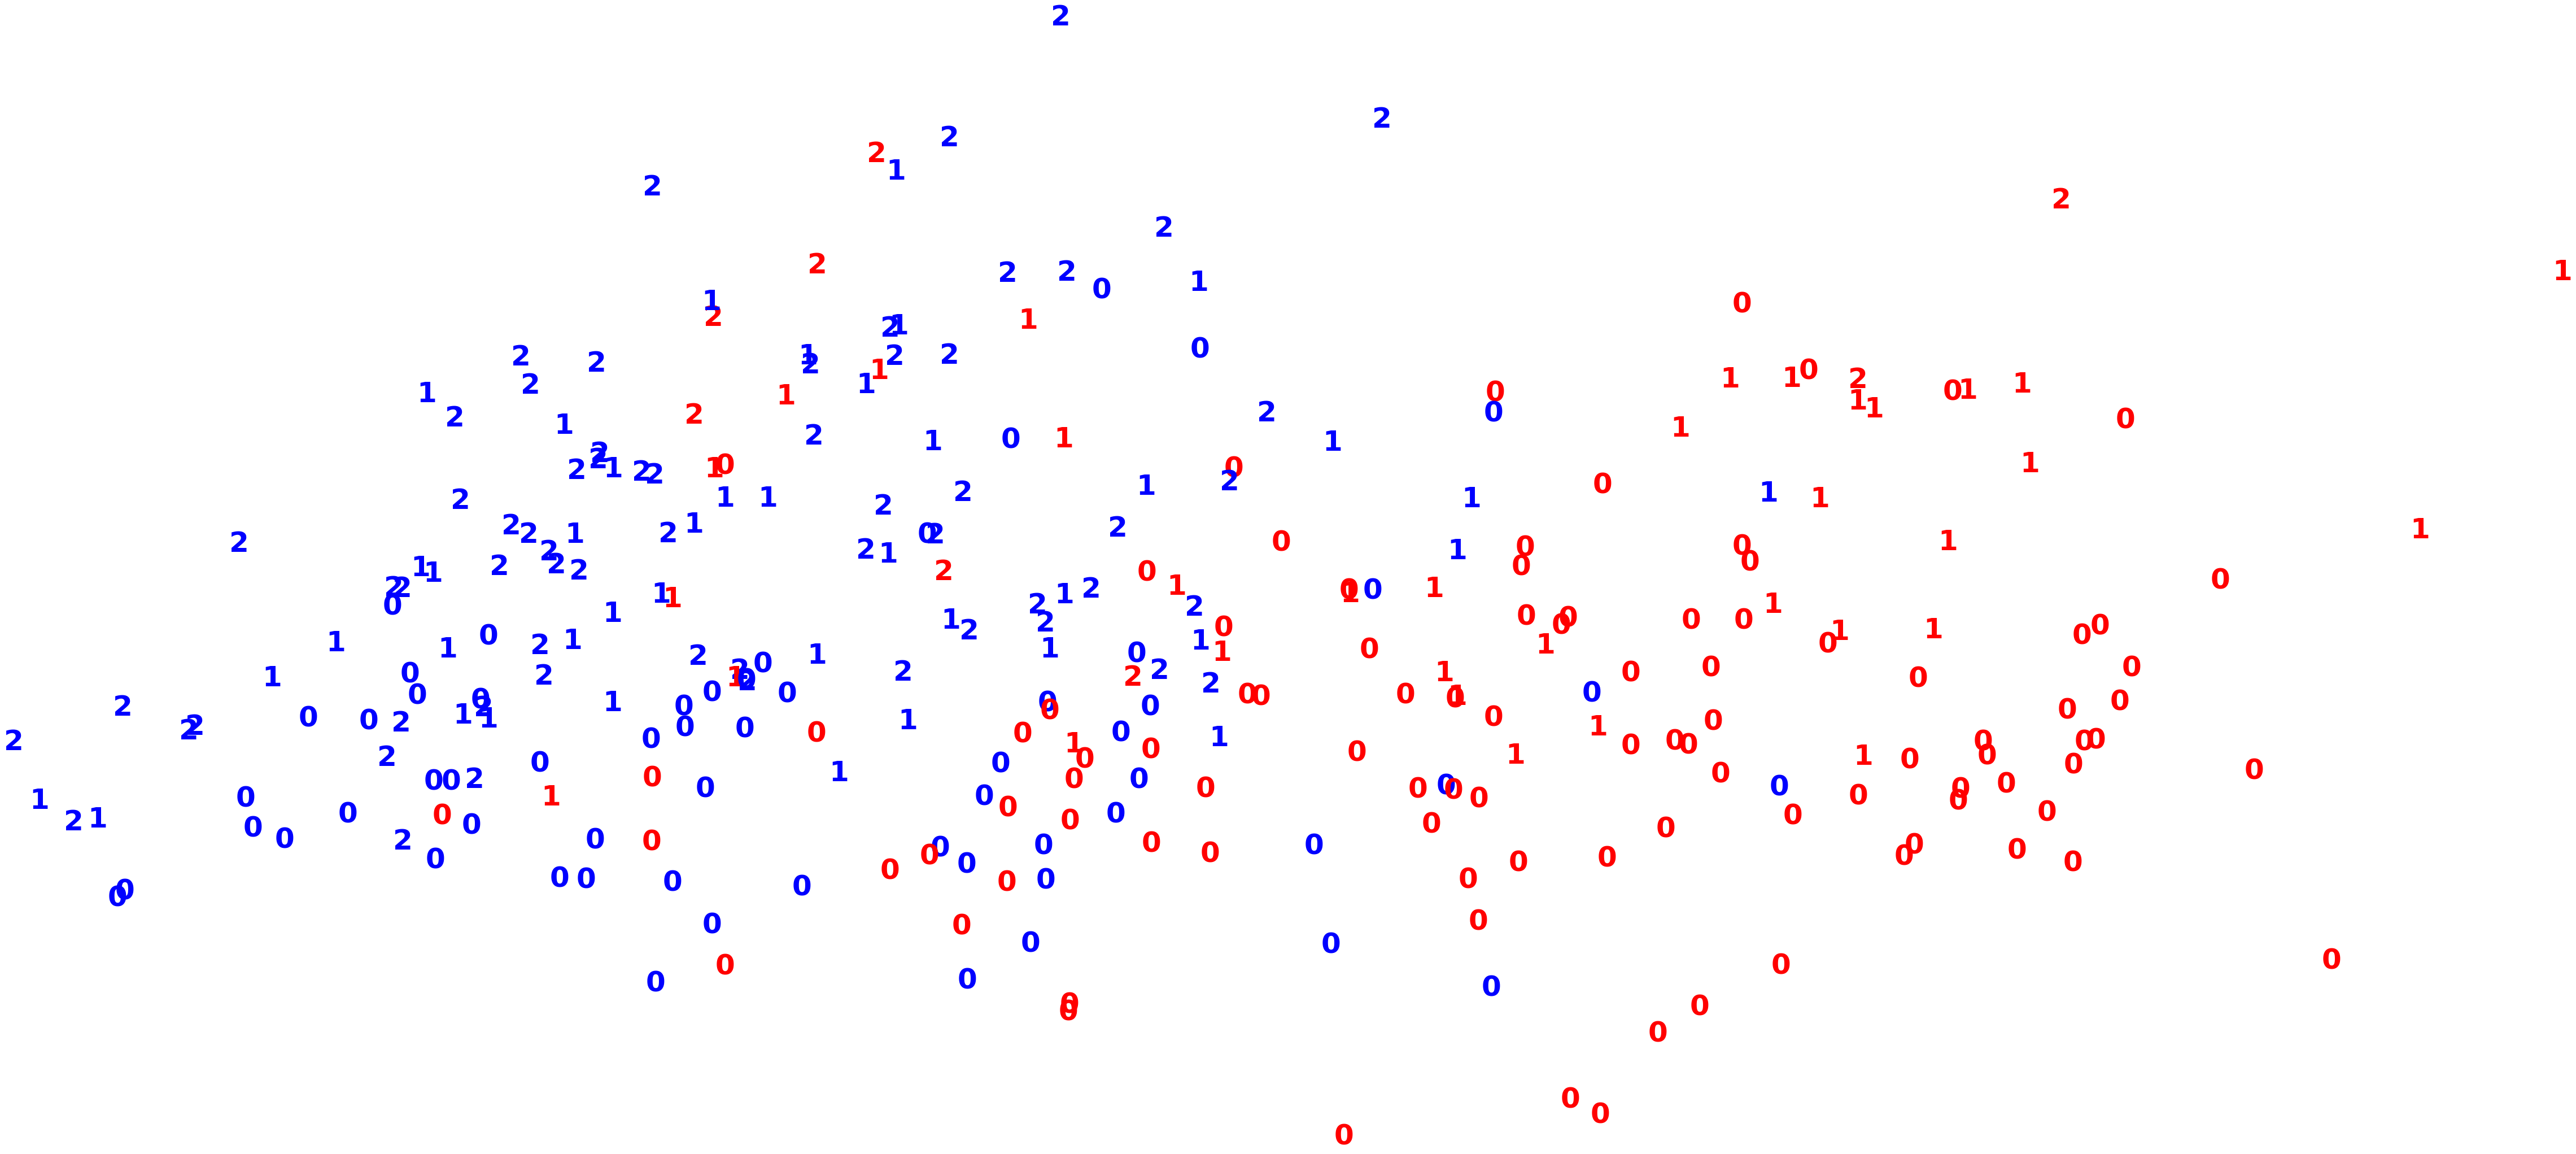

In [46]:
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=3)

# Fit model
clusters = agg_cluster.fit_predict(std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()